In [23]:
import os
import sys
from animate_graph import find_last_graph_file
from decentralizepy.graphs.MobilityGraph import MobilityGraph


def get_graphs(graphs_dir) -> list[MobilityGraph]:
    last_graph_file_number = find_last_graph_file(graphs_dir)
    if last_graph_file_number is None:
        print("No graph files found in the directory.")
        sys.exit(1)

    graphs = []
    for i in range(1, last_graph_file_number + 1):
        file_path = os.path.join(graphs_dir, f"graph_{i}.txt")
        if os.path.exists(file_path):
            g = MobilityGraph()
            g.read_graph_from_file(file_path)
            graphs.append(g)
        else:
            print(f"File graph_{i}.txt does not exist in the directory.")
            sys.exit(1)

    return graphs

# graph=f"tutorial/dynamic_48_{str(high_mobility_proportion).replace(".", "_")}.txt"
# graphs=simulate_graph(graph)

experiment_dir = ".saved_experiments/2024-05-30-new-neighbours-1/2024-05-31T00:16-dynamic_48_0_05.txt/machine0"
graphs=get_graphs(experiment_dir)

num_nodes = 48
high_mobility_proportion = 0.4


In [24]:
from collections import defaultdict
import json
import numpy as np
import matplotlib.pyplot as plt    

from simulate_graph import simulate_graph


def average_of_first_percent(lst, p):
    n = int(len(lst) * p)
    return np.mean(lst[:n])

def average_of_last_percent(lst, p):
    n = int(len(lst) * p)
    return np.mean(lst[-n:])



def high_mobility_nodes(g: MobilityGraph):
    n = int(len(g.nodes) * high_mobility_proportion)
    return g.nodes[:n]

def low_mobility_nodes(g: MobilityGraph):  
    n_low = int(len(g.nodes) * high_mobility_proportion)
    return g.nodes[n_low:]

n = len(graphs)
high_mobility_neighbors = [defaultdict(set) for _ in range(n)]
low_mobility_neighbors = [defaultdict(set) for _ in range(n)]

for (i, g) in enumerate(graphs):
    h_nodes = high_mobility_nodes(g)
    l_nodes = low_mobility_nodes(g)

    print("High mobility nodes:", [node.uid for node in h_nodes])
    print("High mobility nodes velocities:", [node.velocity for node in h_nodes])
    print("Low mobility nodes:", [node.uid for node in l_nodes])
    print("Low mobility nodes velocities:", [node.velocity for node in l_nodes])

    for node in h_nodes:
        high_mobility_neighbors[i][node.uid] = set(g.neighbors(node.uid))
    
    for node in l_nodes:
        low_mobility_neighbors[i][node.uid] = set(g.neighbors(node.uid))
    


High mobility nodes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
High mobility nodes velocities: [93.19766072211362, 152.83303815651334, 91.3936010246992, 23.890952992706925, 1.678996558684226, 37.12596884547416, 43.66382592112502, 45.11585212870255, 31.50086272393254, 48.30087073651006, 49.128928702913136, 2.1510005296187296, 41.43811971540964, 20.811817704309345, 46.85800302396693, 32.76408942058433, 25.620520869069047, 12.107393425278362, 13.163111587661291]
Low mobility nodes: [19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]
Low mobility nodes velocities: [19.201516574536413, 14.763954731711031, 21.492890569487642, 12.96195868517841, 37.72182580666457, 2.458768800628097, 47.58705126160458, 40.50388903996271, 41.21989303449419, 17.72089195450992, 11.467239307323801, 45.52961846558604, 37.89267294219741, 42.745307218048126, 47.60165291258941, 6.284072388728551, 13.811751257968286, 47.0115354465

In [25]:
average_high_mobility_velocity = [np.mean([node.velocity for node in high_mobility_nodes(g)]) for g in graphs][0]
average_low_mobility_velocity = [np.mean([node.velocity for node in low_mobility_nodes(g)]) for g in graphs][0]

print("Average High Mobility Velocity:", average_high_mobility_velocity)
print("Average Low Mobility Velocity:", average_low_mobility_velocity)

Average High Mobility Velocity: 42.77603235733013
Average Low Mobility Velocity: 25.438952275270672


[1.5263157894736843, 3.0, 4.947368421052632, 2.210526315789474, 2.526315789473684, 1.9473684210526316, 1.736842105263158, 2.8947368421052633, 1.7894736842105263, 1.0526315789473684, 2.4210526315789473, 2.1578947368421053, 1.8421052631578947, 5.052631578947368, 3.263157894736842, 2.526315789473684, 1.8421052631578947, 2.1052631578947367, 3.210526315789474, 2.789473684210526, 2.5789473684210527, 2.736842105263158, 3.0, 2.0, 2.210526315789474, 3.210526315789474, 2.0, 2.8947368421052633, 1.3157894736842106, 1.9473684210526316, 3.736842105263158, 3.210526315789474, 2.473684210526316, 2.9473684210526314, 2.3684210526315788, 2.8421052631578947, 1.736842105263158, 2.4210526315789473, 2.4210526315789473, 1.5789473684210527, 2.526315789473684, 1.8421052631578947, 1.0, 1.4210526315789473, 1.5263157894736843, 2.8947368421052633, 3.0, 2.210526315789474, 1.9473684210526316, 1.4210526315789473, 2.4210526315789473, 1.5789473684210527, 3.0526315789473686, 2.6315789473684212, 3.1052631578947367, 1.73684

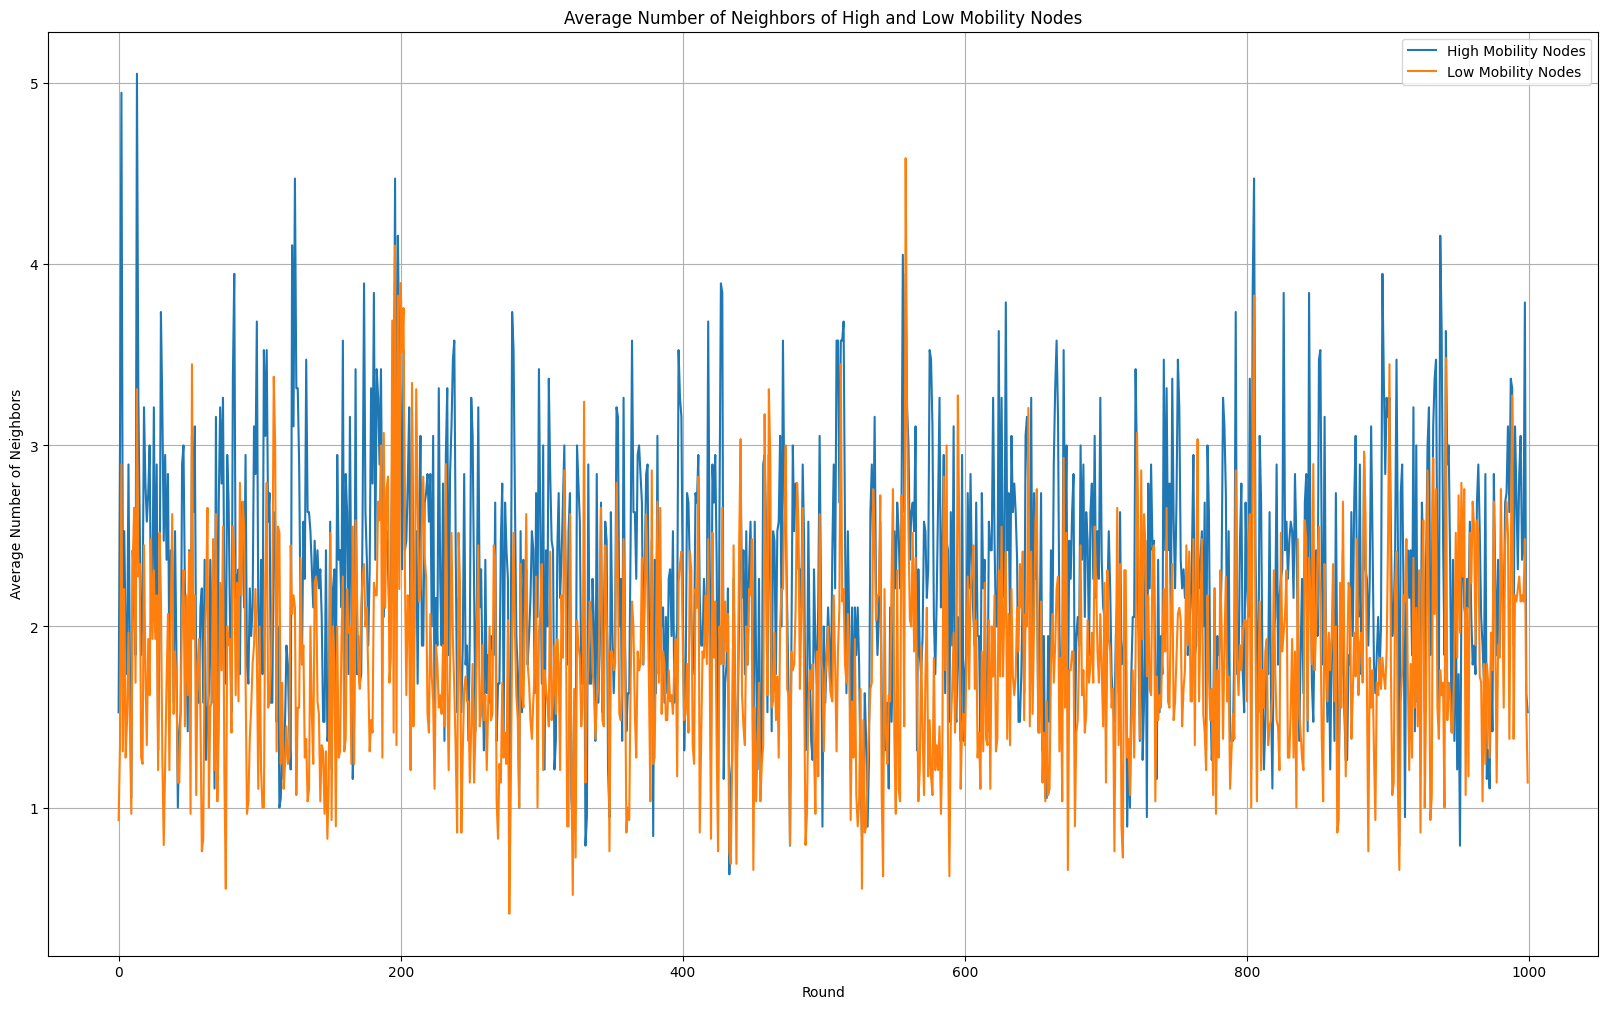

In [26]:
plt.figure(figsize=(20, 12))

average_num_neighbors_high_mobility = [np.mean([len(high_mobility_neighbors[i][node.uid]) for node in high_mobility_nodes(g)]) for i, g in enumerate(graphs)]
average_num_neighbors_low_mobility = [np.mean([len(low_mobility_neighbors[i][node.uid]) for node in low_mobility_nodes(g)]) for i, g in enumerate(graphs)]

print(average_num_neighbors_high_mobility)
print(average_num_neighbors_low_mobility)

plt.plot(average_num_neighbors_high_mobility, label="High Mobility Nodes")
plt.plot(average_num_neighbors_low_mobility, label="Low Mobility Nodes")

plt.xlabel("Round")
plt.ylabel("Average Number of Neighbors")
plt.title("Average Number of Neighbors of High and Low Mobility Nodes")
plt.legend()
plt.grid(True)
plt.show()


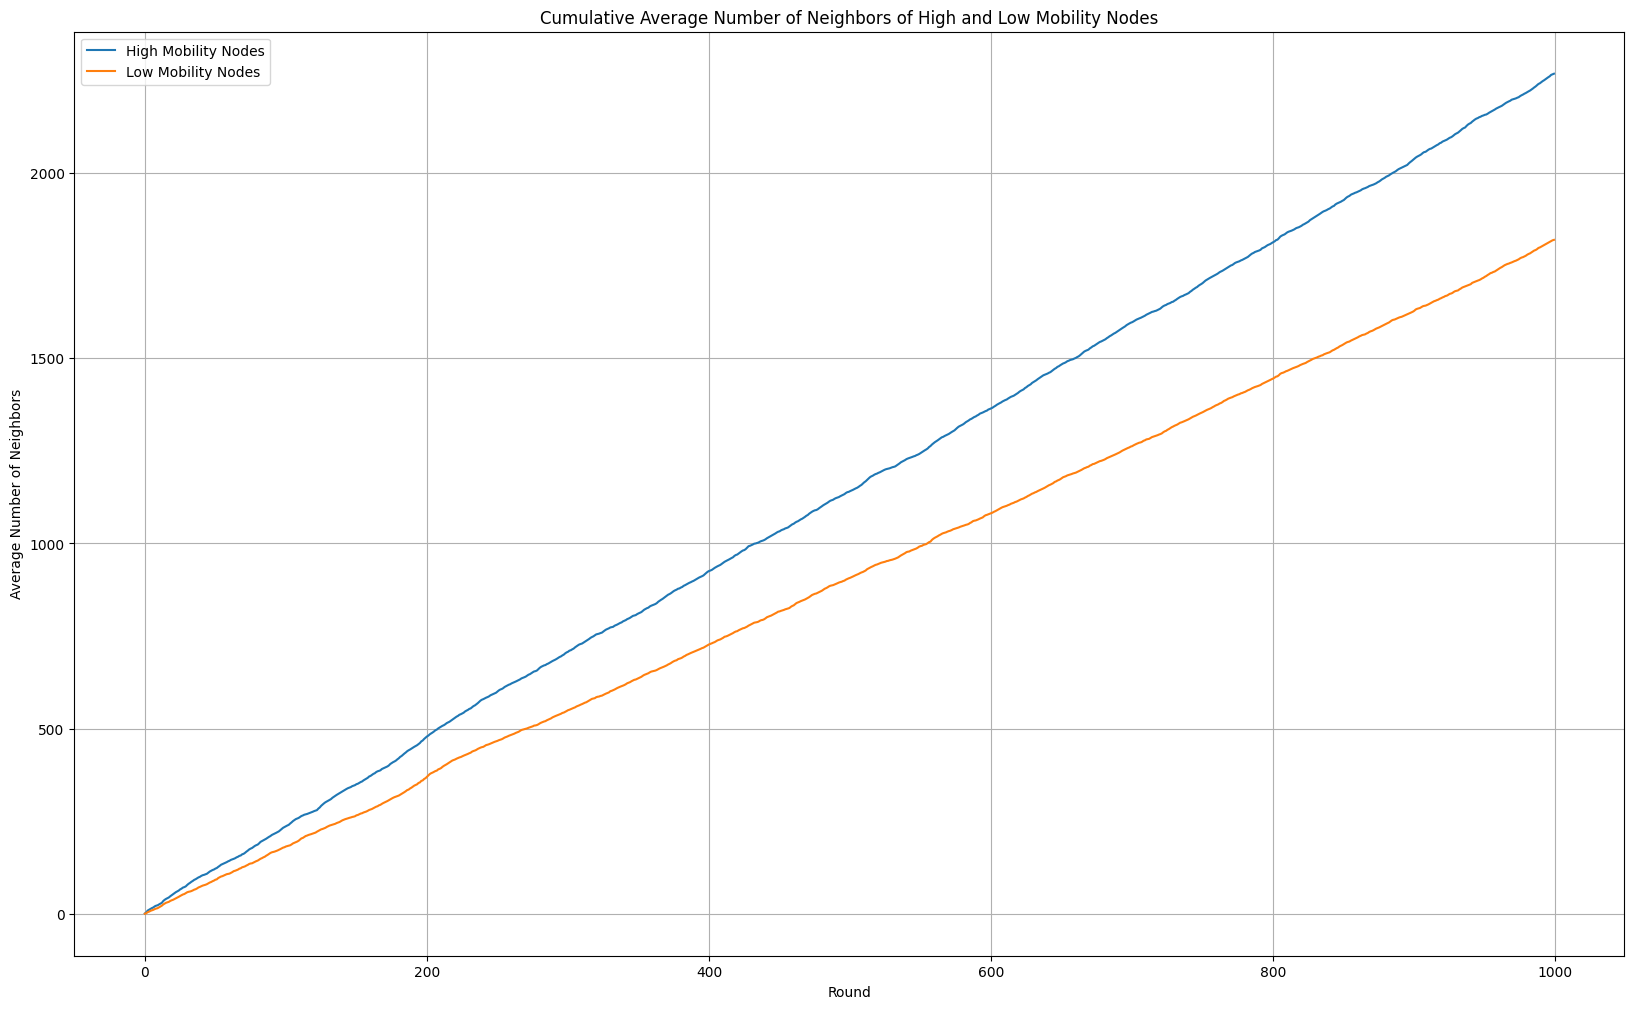

In [27]:
cumulative_num_neighbors_high_mobility = np.cumsum(np.array(average_num_neighbors_high_mobility))
cumulative_num_neighbors_low_mobility = np.cumsum(np.array(average_num_neighbors_low_mobility))

plt.figure(figsize=(20, 12))

plt.plot(cumulative_num_neighbors_high_mobility, label="High Mobility Nodes")
plt.plot(cumulative_num_neighbors_low_mobility, label="Low Mobility Nodes")

plt.xlabel("Round")
plt.ylabel("Average Number of Neighbors")
plt.title("Cumulative Average Number of Neighbors of High and Low Mobility Nodes")
plt.legend()
plt.grid(True)


[64.3427847648351, 74.38750170675326, 87.77829300016845, 64.34278476483512, 64.34278476483512, 85.72615286757544, 74.38750170675324, 91.08291212520597, 59.281541755002365, 66.39492489742811, 87.77829300016845, 42.77603235733013, 64.00751964822379, 119.10700816516824, 102.38450712920321, 82.28145094195683, 69.50964300168518, 80.70293006667652, 97.20843946434877, 80.51302904589605, 90.74113029257884, 80.42586504943257, 80.51302904589605, 69.69954402246564, 64.34278476483512, 102.07978145340103, 69.69954402246564, 63.92035565176032, 42.77603235733013, 81.03819518328784, 99.62293533106539, 101.89639714863637, 80.51302904589605, 99.62293533106539, 81.87923552889083, 103.59883280035135, 81.42532491100287, 83.59651459638185, 89.9010133648836, 42.77603235733013, 77.12920542461194, 64.15940046007044, 42.77603235733013, 42.77603235733013, 42.77603235733012, 98.51257352735226, 53.00413360401294, 86.90342238189862, 42.77603235733012, 42.77603235733012, 42.77603235733013, 42.77603235733012, 88.0454

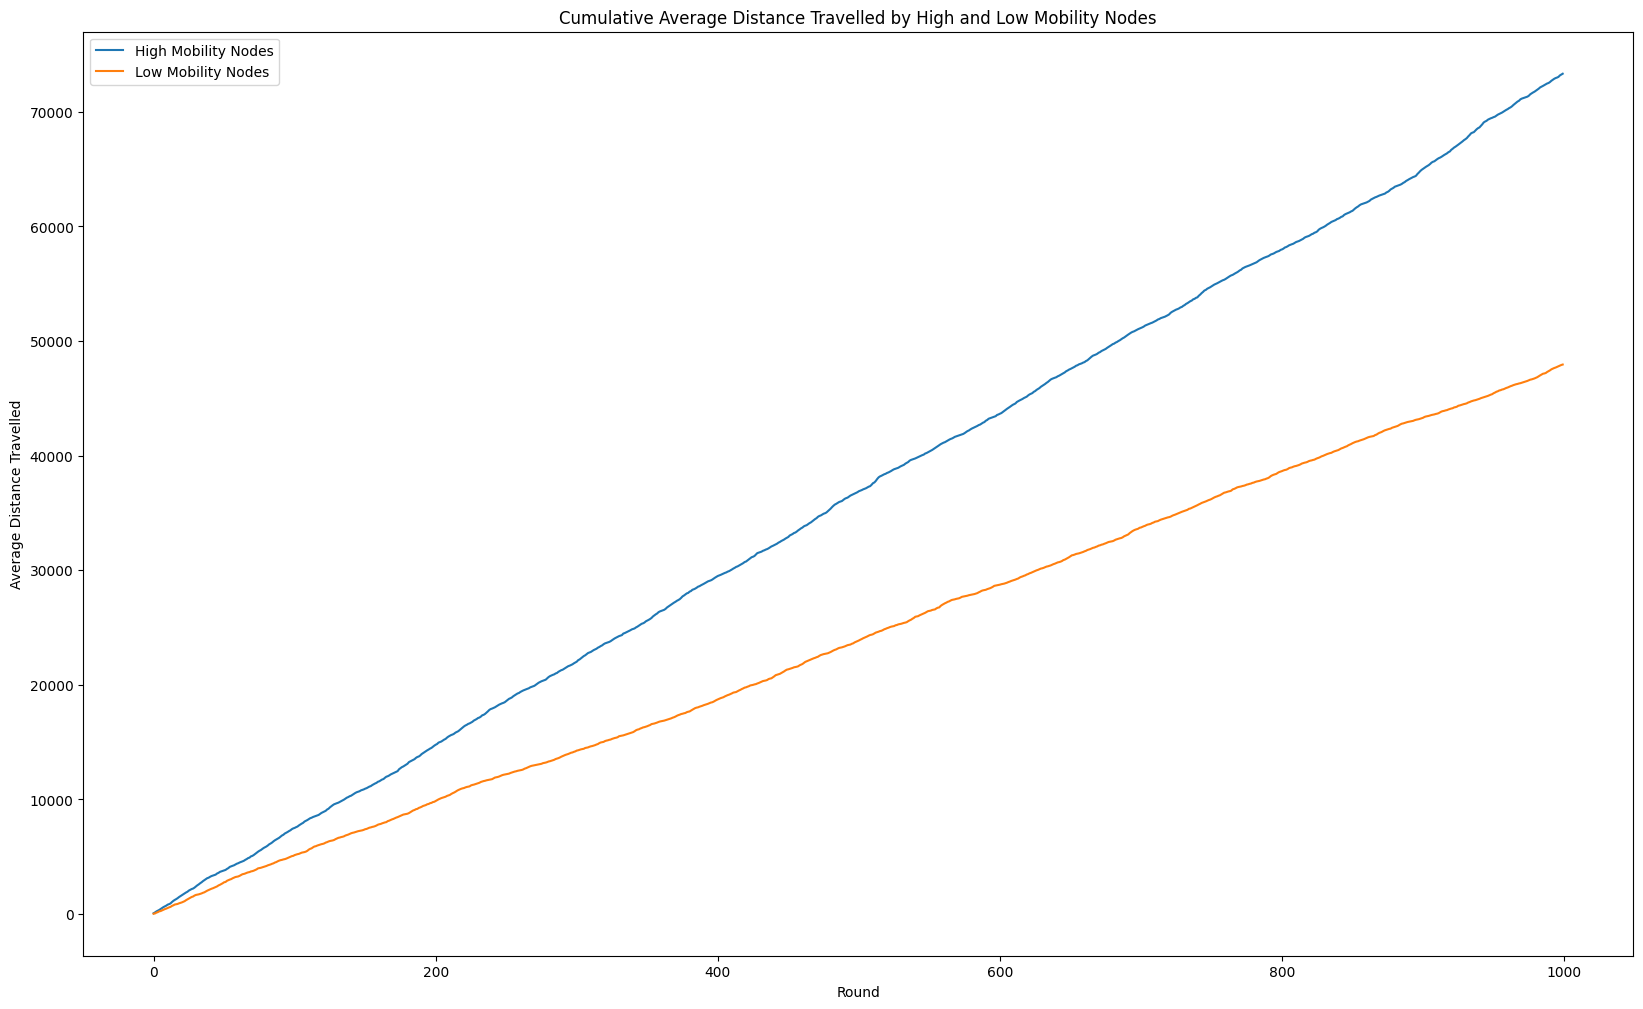

In [28]:
from decentralizepy.graphs.MobilityNode import MobilityNode


def get_node_distance_travelled(node: MobilityNode):
    return np.linalg.norm(np.array(node.pos_vec) - np.array(node.previous_pos_vec))

high_mobility_nodes_distances = [np.mean([get_node_distance_travelled(node) for node in high_mobility_nodes(g)]) for g in graphs]
low_mobility_nodes_distances = [np.mean([get_node_distance_travelled(node) for node in low_mobility_nodes(g)]) for g in graphs]
print(high_mobility_nodes_distances)
print(low_mobility_nodes_distances)

cum_high_mobility_nodes_distances = np.cumsum(np.array(high_mobility_nodes_distances))
cum_low_mobility_nodes_distances = np.cumsum(np.array(low_mobility_nodes_distances))

plt.figure(figsize=(20, 12))

plt.plot(cum_high_mobility_nodes_distances, label="High Mobility Nodes")
plt.plot(cum_low_mobility_nodes_distances, label="Low Mobility Nodes")

plt.xlabel("Round")
plt.ylabel("Average Distance Travelled")
plt.title("Cumulative Average Distance Travelled by High and Low Mobility Nodes")
plt.legend()
plt.show()